In [85]:
import pandas as pd
import seaborn as sns
import requests
import json
import os
import datetime

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)
pd.set_option('display.width', 999)


In [86]:
amsterdam_weather = pd.read_csv("data/amsterdam.csv")
rotterdam_weather = pd.read_csv("data/rotterdam.csv")
hague_weather = pd.read_csv("data/hague.csv")

#display(hague_weather)

In [87]:
files = os.listdir('data/dutch_tweets/')
df = pd.DataFrame()

for file in files:
    dfTemp = pd.read_json(f'data/dutch_tweets/{file}')
    df = pd.concat([df, dfTemp])
df.dropna(subset=['longitude', 'latitude'], inplace=True)
df['longitude'] = df['longitude'].round(1)
df['latitude'] = df['latitude'].round(1)
df = df[df['subjective_pattern'] != 0]

# Use apply with a lambda function for concatenation
df['lat_long'] = df.apply(lambda row: str(row['latitude']) + ', ' + str(row['longitude']), axis=1)

def unix_ms_to_datetime(date):
    if(type(date) == 'timestamp'):
        return date.tz_localize(None)
    elif isinstance(date, str) and ':' in date: 
        return pd.to_datetime(date).tz_localize(None)
    else:
        return pd.to_datetime(date, unit='ms').tz_localize(None)

df['created_at'] = df['created_at'].apply(unix_ms_to_datetime)

amsterdam_lat_long = '52.4, 4.9'
rotterdam_lat_long = '51.9, 4.5'
hague_lat_long = '52.1, 4.3'

amsterdam_tweets = df[df['lat_long'] == '52.4, 4.9']
rotterdam_tweets = df[df['lat_long'] == '51.9, 4.5']
hague_tweets = df[df['lat_long'] == '52.1, 4.3']

display(hague_tweets)

,full_text,text_translation,created_at,screen_name,description,desc_translation,weekofyear,weekday,day,month,year,location,point_info,point,latitude,longitude,altitude,province,hisco_standard,hisco_code,industry,sentiment_pattern,subjective_pattern,lat_long
80,RT @thierrybaudet: FVD lanceert: plan intellig...,RT @thierrybaudet: FVD launches: plan intellig...,2020-04-08 06:59:52,thijssen_pieter,Ondernemer die zich zorgen maakt over huidige ...,Entrepreneur worried about current policies on...,15.0,2.0,8.0,4.0,2020.0,Den Haag,"Den Haag, Zuid-Holland, Nederland","(52.0799838, 4.3113461, 0.0)",52.1,4.3,0.0,Zuid-Holland,None,None,False,0.800000,0.900000,"52.1, 4.3"
111,RT @sandravogelaar: Hoe noem je eigenlijk een ...,@Sandravogelaar RT: What do you call people wh...,2020-04-08 06:13:12,michael51740963,happy single .\nwe are getting f**ked by gover...,happy single.\nWe are getting f ** ked by gove...,15.0,2.0,8.0,4.0,2020.0,"Den Haag, Nederland","Den Haag, Zuid-Holland, Nederland","(52.0799838, 4.3113461, 0.0)",52.1,4.3,0.0,Zuid-Holland,vogelaar,64960,True,0.200000,0.508333,"52.1, 4.3"
118,RT @PharosKennis: Nieuw: 80 moeilijke woorden ...,RT @PharosKennis: New: 80 difficult words on t...,2020-04-08 06:13:34,LeergeldDenHaag,Alle kinderen gelijke kansen,All children equal opportunities,15.0,2.0,8.0,4.0,2020.0,"The Hague, The Netherlands","Den Haag, Zuid-Holland, Nederland","(52.0799838, 4.3113461, 0.0)",52.1,4.3,0.0,Zuid-Holland,None,None,False,0.016667,0.950000,"52.1, 4.3"
341,“Sociale onthouding leidt tot sociale herwaard...,"""Social deprivation leads to social revaluatio...",2020-04-08 06:57:40,HarmTilman,"Editor-in-Chief 'de Architect', magazine & web...","Editor-in-Chief ""Architect"" magazine & website...",15.0,2.0,8.0,4.0,2020.0,"The Hague, the Netherlands","Den Haag, Zuid-Holland, Nederland","(52.0799838, 4.3113461, 0.0)",52.1,4.3,0.0,Zuid-Holland,waard,51020,True,0.288889,0.455556,"52.1, 4.3"
664,RT @BelowTheNote: I’m not too mad at the littl...,@BelowTheNote RT: I'm not too mad at the littl...,2020-07-22 05:26:14,cummybear3008,chubby cummy bottom bear,cummy bottom chubby bear,30.0,2.0,22.0,7.0,2020.0,"The Hague, The Netherlands","Den Haag, Zuid-Holland, Nederland","(52.0799838, 4.3113461, 0.0)",52.1,4.3,0.0,Zuid-Holland,None,None,False,0.400000,0.600000,"52.1, 4.3"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26891,@LudoTausch Wie vragen erom en waarom. Ik heb ...,@LudoTausch who ask for it and why. I explaine...,2020-08-24 12:48:44,LokaalGeld,"St. Lokaal Geld, Vrijheidsschrijver, SEO, Were...","St. Local Money, Freedom Writers, SEO, World t...",35.0,0.0,24.0,8.0,2020.0,Den Haag,"Den Haag, Zuid-Holland, Nederland","(52.0799838, 4.3113461, 0.0)",52.1,4.3,0.0,Zuid-Holland,None,None,False,-0.312500,0.450000,"52.1, 4.3"
27003,RT @drsmichakat: MENSEN WE KRIJGEN STEEDS MEER...,RT @drsmichakat: PEOPLE WE GET MORE AND MORE D...,2020-08-24 12:52:29,XMASHCF,My Kids // CHELSEA FC DEN HAAG // Football // ...,My Kids // CHELSEA FC THE HAGUE // Football //...,35.0,0.0,24.0,8.0,2020.0,Den Haag / The Hague,"Den Haag, Zuid-Holland, Nederland","(52.0799838, 4.3113461, 0.0)",52.1,4.3,0.0,Zuid-Holland,None,None,False,-0.375000,0.700000,"52.1, 4.3"
27028,Zie Twente op z'n allermooist tijdens de KNAC ...,See Twente at its most beautiful during KNAC A...,2020-08-24 12:53:21,KNACnl,Koninklijke Nederlandsche Automobiel Club. Voo...,Royal Dutch Automobile Club. For those with a ...,35.0,0.0,24.0,8.0,2020.0,Den Haag,"Den Haag, Zuid-Holland, Nederland","(52.0799838, 4.3113461, 0.0)",52.1,4.3,0.0,Zuid-Holland,ober,53210,True,0.600000,0.700000,"52.1, 4.3"
27135,It was such a pleasure and honour to join the ...,It was Such a pleasure and honor to join the @...,2020-09-10 18:22:00,SLVeriter,Doctoral researcher @ISGA_Hague 🔍 EU foreign p...,Doctoral researcher @ISGA_Hague 🔍 EU foreign p...,37.0,3.0,10.0,9.0,2020.0,"The Hague, The Netherlands","Den Haag, Zuid-Holland, Nederland","(52.0799838, 4.3113461

In [88]:
# Compute approximate times for tweets. These are used in the next cell to assign the appropriate weather to it.

MORNING_HOUR = 10
AFTERNOON_HOUR = 16

# Tolerance values
MORNING_TOL_BEFORE = 3
MORNING_TOL_AFTER = 3
AFTERNOON_TOL_BEFORE = 3
AFTERNOON_TOL_AFTER = 3

def get_approx_time(tweets):

    for index, row in tweets.iterrows():
        time = str(row['created_at'])
        #print(f"{time} turns into...")

        actual_hour = int(time[11:13])
        if MORNING_HOUR - MORNING_TOL_BEFORE <= actual_hour and actual_hour <= MORNING_HOUR + MORNING_TOL_AFTER:
            time = time[:11] + str(MORNING_HOUR) + ":00:00"
        elif AFTERNOON_HOUR - AFTERNOON_TOL_BEFORE <= actual_hour and actual_hour <= AFTERNOON_HOUR + AFTERNOON_TOL_AFTER:
            time = time[:11] + str(AFTERNOON_HOUR) + ":00:00"
        else:
            time = "OUT OF RANGE"
        
        #print(f"    {time}")
        tweets.loc[index, 'approx_time'] = time

get_approx_time(amsterdam_tweets)
get_approx_time(rotterdam_tweets)
get_approx_time(hague_tweets)

#display(hague_tweets)

C:\Users\stock\AppData\Local\Temp\ipykernel_24564\3699746011.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets.loc[index, 'approx_time'] = time
C:\Users\stock\AppData\Local\Temp\ipykernel_24564\3699746011.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets.loc[index, 'approx_time'] = time
C:\Users\stock\AppData\Local\Temp\ipykernel_24564\3699746011.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

In [89]:
# Merge weather data into tweet dataset

merged_amsterdam = pd.merge(amsterdam_tweets, amsterdam_weather, left_on='approx_time', right_on='date')    # 8,158 entries
merged_rotterdam = pd.merge(rotterdam_tweets, rotterdam_weather, left_on='approx_time', right_on='date')    # 1,756 entries
merged_hague = pd.merge(hague_tweets, hague_weather, left_on='approx_time', right_on='date')                # 1,660 entries

display(merged_hague)

,full_text,text_translation,created_at,screen_name,description,desc_translation,weekofyear,weekday,day,month,year,location,point_info,point,latitude,longitude,altitude,province,hisco_standard,hisco_code,industry,sentiment_pattern,subjective_pattern,lat_long,approx_time,Unnamed: 0,date,coordinates,model (name),model elevation,utc_offset,surface_pressure,surface_solar_radiation,relative_humidity
0,RT @ActionAid_NL: Belangrijke boodschap door a...,RT @ActionAid_NL: Important Message by ambassa...,2020-04-30 18:10:26,MetteGonggrijp,Ambassador #WomensRights & #GenderEquality @Du...,Ambassador #WomensRights & #GenderEquality @Du...,18.0,3.0,30.0,4.0,2020.0,"The Hague, The Netherlands","Den Haag, Zuid-Holland, Nederland","(52.0799838, 4.3113461, 0.0)",52.1,4.3,0.0,Zuid-Holland,None,None,False,0.3500,0.850,"52.1, 4.3",2020-04-30 16:00:00,198,2020-04-30 16:00:00,"(52.1, 4.3)",era5,0.19,1.0,99749.76,576.42,0.55
1,Gezinsleden van met coronavirus besmette patië...,Family members of patients infected with coron...,2020-02-29 16:18:42,lisakarina,#stayhomesafelives,#stayhomesafelives,9.0,5.0,29.0,2.0,2020.0,Scheveningen Netherlands,"Scheveningen, Den Haag, Zuid-Holland, Nederlan...","(52.1062075, 4.2752714, 0.0)",52.1,4.3,0.0,Zuid-Holland,patiënt,-2,True,0.0500,0.400,"52.1, 4.3",2020-02-29 16:00:00,76,2020-02-29 16:00:00,"(52.1, 4.3)",era5,0.19,1.0,98629.36,226.84,0.74
2,@thedailybeast 9) #COVID_19 #update #statistic...,@thedailybeast 9) # COVID_19 #update #statisti...,2020-02-29 16:22:53,BertoJongman100,"Former military intelligence analyst, speciali...","Former military intelligence analyst, speciali...",9.0,5.0,29.0,2.0,2020.0,"The Hague, The Netherlands","Den Haag, Zuid-Holland, Nederland","(52.0799838, 4.3113461, 0.0)",52.1,4.3,0.0,Zuid-Holland,None,None,False,0.1500,0.450,"52.1, 4.3",2020-02-29 16:00:00,76,2020-02-29 16:00:00,"(52.1, 4.3)",era5,0.19,1.0,98629.36,226.84,0.74
3,@Sindyxinli @PeterLoftus44 @EarthUncutTV @MFA_...,@Sindyxinli @ PeterLoftus44 @EarthUncutTV @MFA...,2020-03-04 19:10:36,Alexand62524052,To be a better man,To be a better man,10.0,2.0,4.0,3.0,2020.0,"The Hague, The Netherlands","Den Haag, Zuid-Holland, Nederland","(52.0799838, 4.3113461, 0.0)",52.1,4.3,0.0,Zuid-Holland,None,None,False,1.0000,1.000,"52.1, 4.3",2020-08-31 16:00:00,444,2020-08-31 16:00:00,"(52.1, 4.3)",era5,0.19,1.0,102052.80,439.71,0.56
4,Waarom is handen wassen zo belangrijk om de ve...,Why is hand washing so important to spread the...,2020-08-03 07:44:09,RodeKruis,Leer alles over #EHBO via ons nieuwe kanaal op...,Learn about #EHBO our new channel on Instagram...,32.0,0.0,3.0,8.0,2020.0,"Den Haag, Nederland","Den Haag, Zuid-Holland, Nederland","(52.0799838, 4.3113461, 0.0)",52.1,4.3,0.0,Zuid-Holland,None,None,False,0.2250,0.725,"52.1, 4.3",2020-08-03 10:00:00,387,2020-08-03 10:00:00,"(52.1, 4.3)",era5,0.19,1.0,101424.20,350.78,0.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1655,@LudoTausch Wie vragen erom en waarom. Ik heb ...,@LudoTausch who ask for it and why. I explaine...,2020-08-24 12:48:44,LokaalGeld,"St. Lokaal Geld, Vrijheidsschrijver, SEO, Were...","St. Local Money, Freedom Writers, SEO, World t...",35.0,0.0,24.0,8.0,2020.0,Den Haag,"Den Haag, Zuid-Holland, Nederland","(52.0799838, 4.3113461, 0.0)",52.1,4.3,0.0,Zuid-Holland,None,None,False,-0.3125,0.450,"52.1, 4.3",2020-08-24 10:00:00,429,2020-08-24 10:00:00,"(52.1, 4.3)",era5,0.19,1.0,101481.56,395.03,0.76
1656,RT @drsmichakat: MENSEN WE KRIJGEN STEEDS MEER...,RT @drsmichakat: PEOPLE WE GET MORE AND MORE D...,2020-08-24 12:52:29,XMASHCF,My Kids // CHELSEA FC DEN HAAG // Football // ...,My Kids // CHELSEA FC THE HAGUE // Football //...,35.0,0.0,24.0,8.0,2020.0,Den Haag / The Hague,"Den Haag, Zuid-Holland, Nederland","(52.0799838, 4.3113461, 0.0)",52.1,4.3,0.0,Zuid-Holland,None,None,False,-0.3750,0.700,"52.1, 4.3",2020-08-24 10:00:00,429,2020-08-24 10:00:00,"(52.1, 4.3)",era5,0.19,1.0,101481.56,

Dataset: Amsterdam
POSITIVE COUNT:  5538      NEGATIVE COUNT:  2620
X AXIS: surface_pressure      Y AXIS: surface_solar_radiation
Counts Table:
x_bin               (98549.56, 99184.35]  (99184.35, 99819.14]  (99819.14, 100453.93]  (100453.93, 101088.72]  (101088.72, 101723.51]  (101723.51, 102358.3]  (102358.3, 102993.09]  (102993.09, 103627.88]
y_bin                                                                                                                                                                                                      
(611.356, 697.05]                      0                     0                      0                      23                      48                    111                    196                      20
(525.662, 611.356]                     0                     0                      0                      87                     176                    163                     49                      28
(439.969, 525.662]                     0

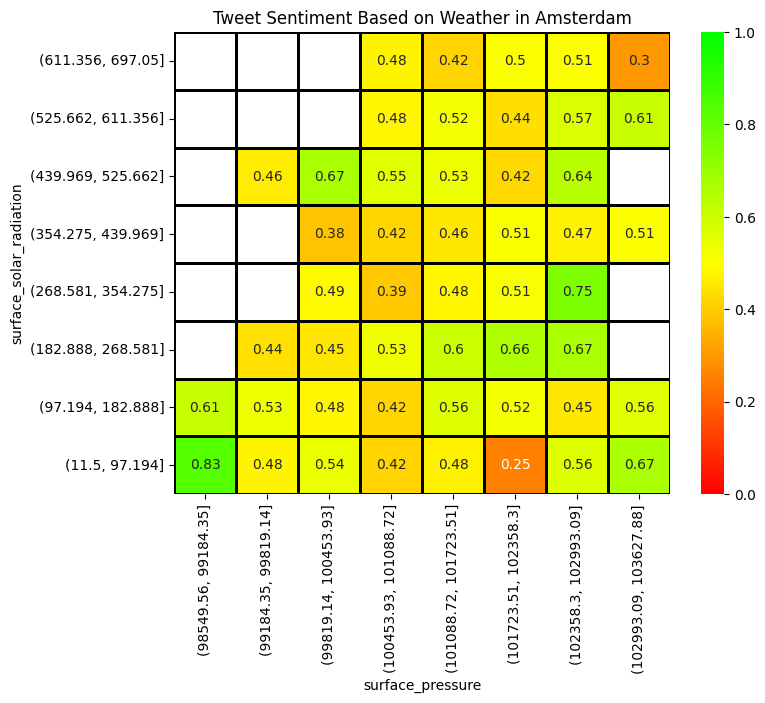

X AXIS: surface_pressure      Y AXIS: relative_humidity
Counts Table:
x_bin           (98549.56, 99184.35]  (99184.35, 99819.14]  (99819.14, 100453.93]  (100453.93, 101088.72]  (101088.72, 101723.51]  (101723.51, 102358.3]  (102358.3, 102993.09]  (102993.09, 103627.88]
y_bin                                                                                                                                                                                                  
(0.884, 0.96]                     21                     0                     75                     126                      70                     79                      9                      28
(0.808, 0.884]                     0                    94                     63                     407                     244                     65                     13                      14
(0.731, 0.808]                    25                    99                    168                      52                     383 

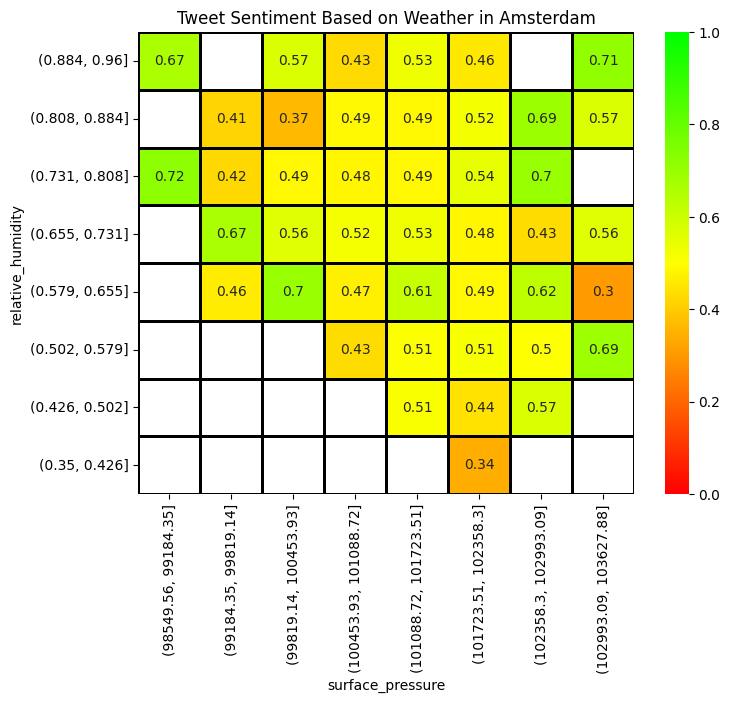

X AXIS: surface_solar_radiation      Y AXIS: relative_humidity
Counts Table:
x_bin           (11.5, 97.194]  (97.194, 182.888]  (182.888, 268.581]  (268.581, 354.275]  (354.275, 439.969]  (439.969, 525.662]  (525.662, 611.356]  (611.356, 697.05]
y_bin                                                                                                                                                                   
(0.884, 0.96]              170                157                  52                   0                   0                   0                   0                  0
(0.808, 0.884]             207                129                 316                  51                 143                  54                   0                  0
(0.731, 0.808]              59                143                 244                 227                 285                  14                  54                  0
(0.655, 0.731]              15                112                  80         

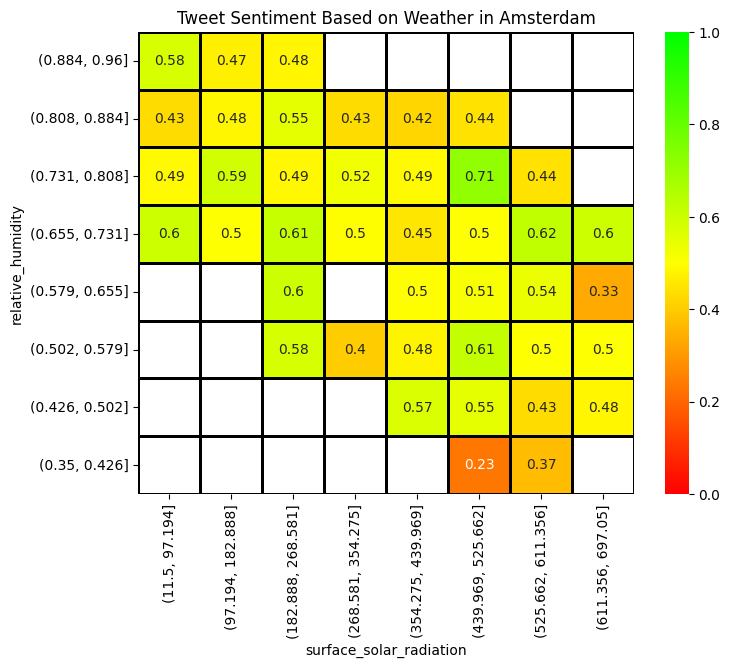

Dataset: Rotterdam
POSITIVE COUNT:  1163      NEGATIVE COUNT:  593
X AXIS: surface_pressure      Y AXIS: surface_solar_radiation
Counts Table:
x_bin               (98698.4, 99313.425]  (99313.425, 99928.45]  (99928.45, 100543.475]  (100543.475, 101158.5]  (101158.5, 101773.525]  (101773.525, 102388.55]  (102388.55, 103003.575]  (103003.575, 103618.6]
y_bin                                                                                                                                                                                                            
(625.918, 714.22]                      0                      0                       0                       1                       6                       43                       28                       0
(537.615, 625.918]                     0                      9                       0                      39                      17                       46                       15                       7
(449.313, 537.615

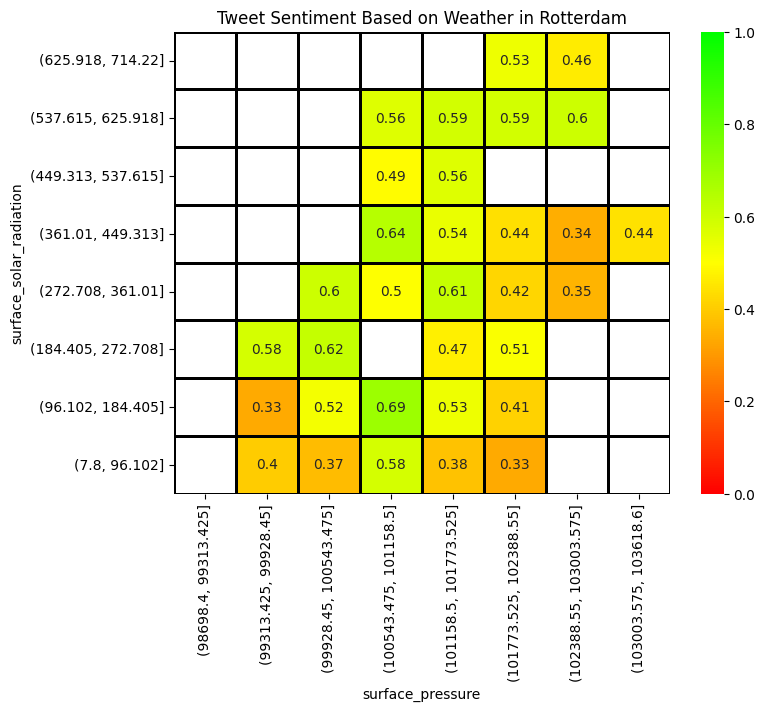

X AXIS: surface_pressure      Y AXIS: relative_humidity
Counts Table:
x_bin           (98698.4, 99313.425]  (99313.425, 99928.45]  (99928.45, 100543.475]  (100543.475, 101158.5]  (101158.5, 101773.525]  (101773.525, 102388.55]  (102388.55, 103003.575]  (103003.575, 103618.6]
y_bin                                                                                                                                                                                                        
(0.871, 0.95]                      3                     11                      22                      11                      19                        1                        8                       6
(0.792, 0.871]                     0                     49                      14                      26                      35                       38                        0                       0
(0.714, 0.792]                     7                      1                      41                      3

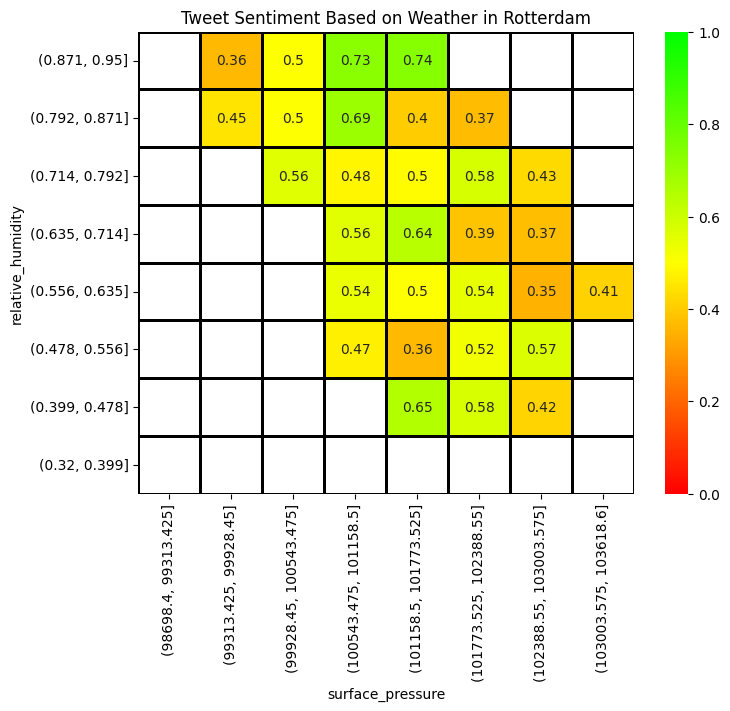

X AXIS: surface_solar_radiation      Y AXIS: relative_humidity
Counts Table:
x_bin           (7.8, 96.102]  (96.102, 184.405]  (184.405, 272.708]  (272.708, 361.01]  (361.01, 449.313]  (449.313, 537.615]  (537.615, 625.918]  (625.918, 714.22]
y_bin                                                                                                                                                                
(0.871, 0.95]              44                 34                   0                  0                  0                   0                   0                  0
(0.792, 0.871]             34                 65                  42                 13                  8                   0                   0                  0
(0.714, 0.792]             22                 28                  33                 58                 66                  10                   5                  0
(0.635, 0.714]              0                  7                  23                 53      

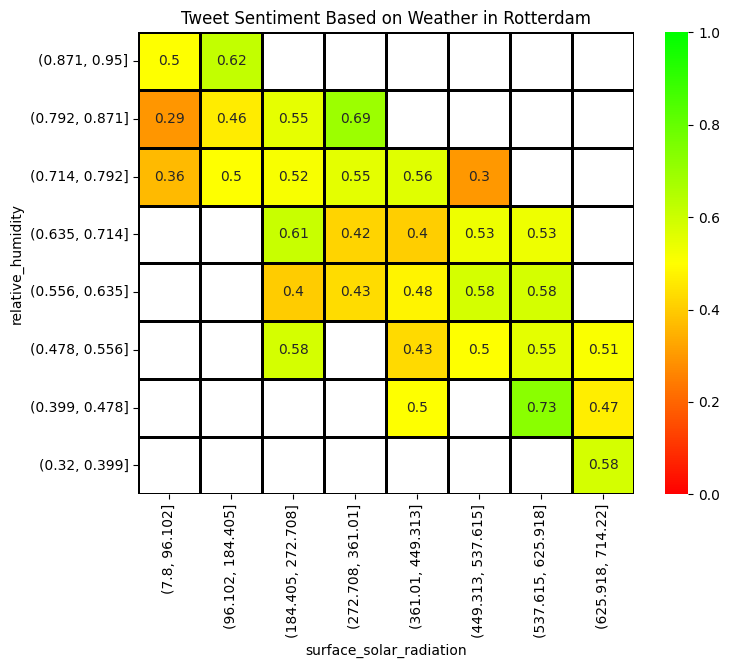

Dataset: The Hague
POSITIVE COUNT:  1077      NEGATIVE COUNT:  583
X AXIS: surface_pressure      Y AXIS: surface_solar_radiation
Counts Table:
x_bin             (98629.36, 99253.245]  (99253.245, 99877.13]  (99877.13, 100501.015]  (100501.015, 101124.9]  (101124.9, 101748.785]  (101748.785, 102372.67]  (102372.67, 102996.555]  (102996.555, 103620.44]
y_bin                                                                                                                                                                                                            
(627.88, 715.86]                      0                      0                       0                       5                      10                       22                       28                        5
(539.9, 627.88]                       0                     12                       0                      26                      36                       80                       27                        5
(451.92, 539.9]  

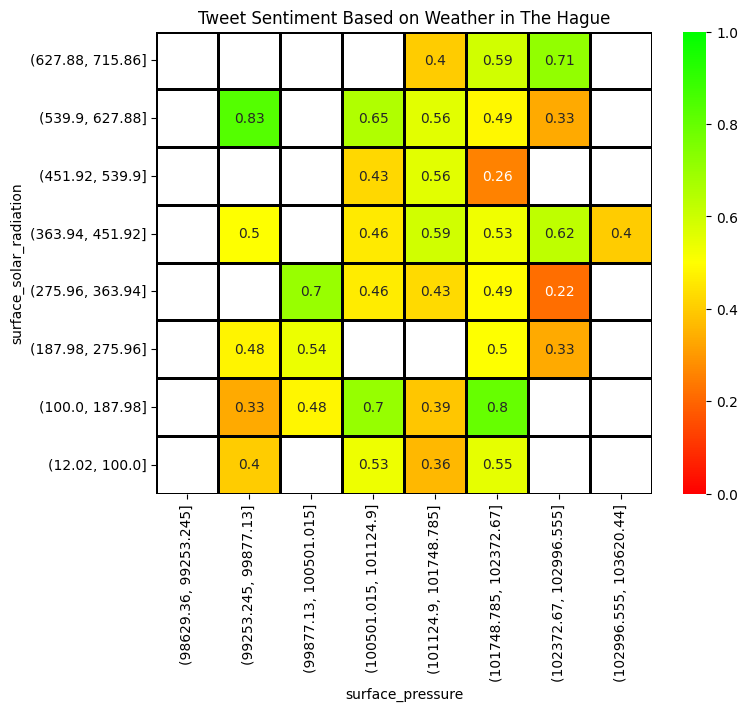

X AXIS: surface_pressure      Y AXIS: relative_humidity
Counts Table:
x_bin         (98629.36, 99253.245]  (99253.245, 99877.13]  (99877.13, 100501.015]  (100501.015, 101124.9]  (101124.9, 101748.785]  (101748.785, 102372.67]  (102372.67, 102996.555]  (102996.555, 103620.44]
y_bin                                                                                                                                                                                                        
(0.87, 0.94]                      1                     17                      13                      35                      15                       20                       11                        0
(0.8, 0.87]                       1                     18                      15                      42                      58                        3                        5                        3
(0.73, 0.8]                       3                     26                      39                      19

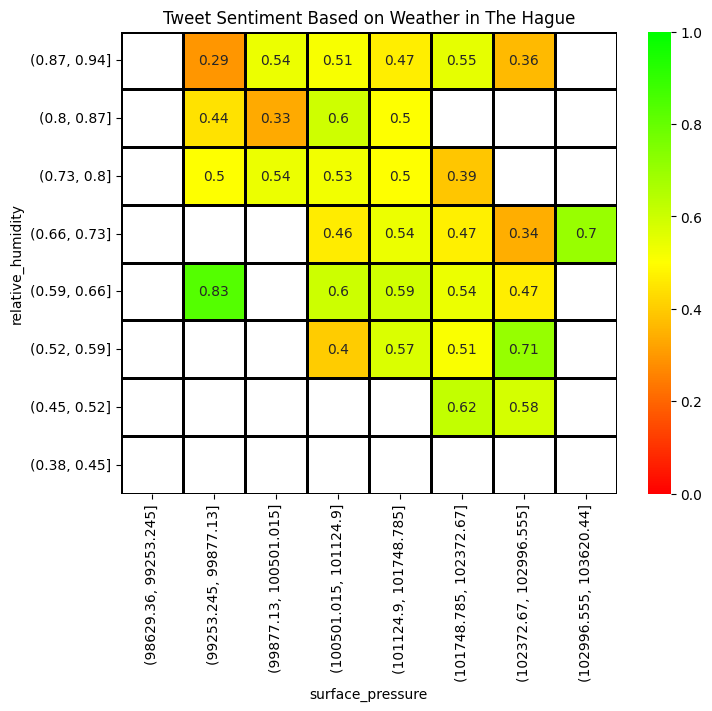

X AXIS: surface_solar_radiation      Y AXIS: relative_humidity
Counts Table:
x_bin         (12.02, 100.0]  (100.0, 187.98]  (187.98, 275.96]  (275.96, 363.94]  (363.94, 451.92]  (451.92, 539.9]  (539.9, 627.88]  (627.88, 715.86]
y_bin                                                                                                                                                  
(0.87, 0.94]              73               27                 0                 0                11                0                0                 0
(0.8, 0.87]               13               45                21                 4                38                3               21                 0
(0.73, 0.8]                7               18                63                60                38               34               15                 0
(0.66, 0.73]               3               13                 5                79                76               69               26                 6
(0.59, 0.66

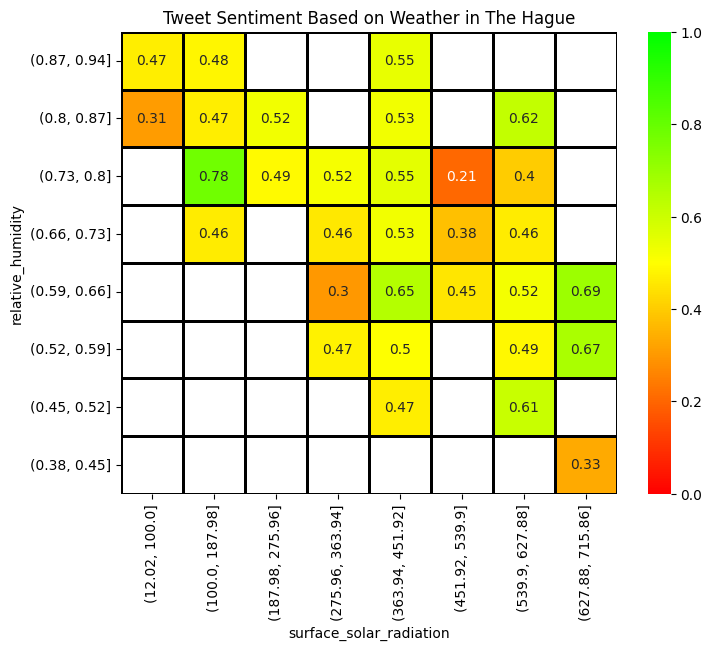

In [90]:
import random

NEGATIVE_MOOD = 0
POSITIVE_MOOD = 1

NUMBER_OF_BINS = 8
BIG_ENOUGH_SAMPLE_SIZE = 10

colors = [(1, 0, 0), (1, 1, 0), (0, 1, 0)]
customColors = LinearSegmentedColormap.from_list('CustomMap', colors, N=256)

weather_attribs = ['surface_pressure', 'surface_solar_radiation', 'relative_humidity']

show_counts_table = True
throwOutSmallSamples = True
binning = True

def runHeapMap(df, df_name):
    print(f"Dataset: {df_name}")
    df['mood'] = np.where(df['sentiment_pattern'] < 0, NEGATIVE_MOOD, POSITIVE_MOOD)

    count_negative_mood = (df['mood'] == NEGATIVE_MOOD).sum()
    count_positive_mood = (df['mood'] == POSITIVE_MOOD).sum()
    total_count = count_negative_mood + count_positive_mood

    print(f"POSITIVE COUNT:  {count_positive_mood}      NEGATIVE COUNT:  {count_negative_mood}")

    # Undersample the data, since there seem to be twice as many positive moods as negatives
    majority_class = df[df['mood'] == POSITIVE_MOOD]
    minority_class = df[df['mood'] == NEGATIVE_MOOD]
    undersampled_majority = majority_class.sample(n=len(minority_class), random_state=42)
    df = pd.concat([undersampled_majority, minority_class])

    for curr_x in range(len(weather_attribs) - 1):
        for curr_y in range(curr_x + 1, len(weather_attribs)):
            x_attribute = weather_attribs[curr_x]
            y_attribute = weather_attribs[curr_y]

            print(f"X AXIS: {x_attribute}      Y AXIS: {y_attribute}")

            if binning:
                # Explicitly specifying bins for surface_pressure and relative_humidity
                surface_pressure_bins = np.linspace(df[x_attribute].min(), df[x_attribute].max(), NUMBER_OF_BINS + 1)
                relative_humidity_bins = np.linspace(df[y_attribute].min(), df[y_attribute].max(), NUMBER_OF_BINS + 1)

                # Binning the weather attributes into ten categories each
                df['x_bin'] = pd.cut(df[x_attribute], bins=surface_pressure_bins)
                df['y_bin'] = pd.cut(df[y_attribute], bins=relative_humidity_bins)
            else:
                df['x_bin'] = df[x_attribute]
                df['y_bin'] = df[y_attribute]

            # Creating pivot table with binned values
            pivot_df = df.pivot_table(index='y_bin', columns='x_bin', values='mood', aggfunc='mean', observed=False)

            pivot_df = pivot_df.iloc[::-1]

            if show_counts_table:
                # Displaying counts table
                counts_table = df.groupby(['y_bin', 'x_bin'], observed=False).size().unstack(fill_value=0)

                if throwOutSmallSamples:
                    pivot_df = pivot_df.where(counts_table >= BIG_ENOUGH_SAMPLE_SIZE)

                counts_table = counts_table.iloc[::-1]  # Reversing rows
                print("Counts Table:")
                print(counts_table)

            plt.figure(figsize=(8, 6))
            sns.heatmap(pivot_df, cmap=customColors, vmin=0, vmax=1, annot=True, linewidths=1, linecolor='black')
            plt.title(f'Tweet Sentiment Based on Weather in {df_name}')
            plt.xlabel(x_attribute)
            plt.ylabel(y_attribute)
            plt.show()

runHeapMap(merged_amsterdam, "Amsterdam")
runHeapMap(merged_rotterdam, "Rotterdam")
runHeapMap(merged_hague, "The Hague")
